# Check run for errors

In [1]:
# imports
import re
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [7]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "test-cases" #"benchmark-data" / "data-processed"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-11-30_runtime-gutentag-2"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-12-02_runtime-benchmark-2-merged'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-11-01_runtime-gutentag-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/2021-11-30_runtime-gutentag-2'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/backup'),
 PosixPath('/home/projects/a


Selecting:
Data path: /home/projects/akita/data/test-cases
Result path: /home/projects/akita/results/2021-11-30_runtime-gutentag-2


Load results and dataset metadata:

In [21]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# aggregate runtime
df["overall_time"] = df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0)

# add RANGE_PR_AUC if it is not part of the results
if "RANGE_PR_AUC" not in df.columns:
    df["RANGE_PR_AUC"] = np.nan

# remove all duplicates (not necessary, but sometimes, we have some)
df = df.drop_duplicates()

df["dataset"] = df["dataset"].astype(str)
#df["dataset"] = df["dataset"].str.split(".").str[0]

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-11-30_runtime-gutentag-2


Define utility functions

In [22]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [23]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_id, use_plotly: bool = default_use_plotly, **kwargs):
    if not isinstance(algorithm_name, list):
        algorithms = [algorithm_name]
    else:
        algorithms = algorithm_name
    # deconstruct dataset ID
    collection_name, dataset_name = dataset_id

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[(df["collection"] == collection_name) & (df["dataset"] == dataset_name), "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo in algorithms:
        algos.append(algo)
        # get algorithm metric results
        try:
            auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["collection"] == collection_name) & (df["dataset"] == dataset_name), "ROC_AUC"].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_id}.")
            auroc[algo] = -1
            skip_algos.append(algo)
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[algo] = load_scores_df(algo, dataset_id).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_id}.")
            df_scores[algo] = np.nan
            skip_algos.append(algo)
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=df_dataset.columns[i]), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for algo in algorithms:
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[algo], name=f"{algo}={auroc[algo]:.4f}"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique(algorithms))} on {dataset_id}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=df_dataset.columns[i])
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for algo in algorithms:
        axs[1].plot(df_scores.index, df_scores[algo], label=f"{algo}={auroc[algo]:.4f}")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique(algorithms))} on {dataset_id}")
    fig.tight_layout()
    return fig

def plot_boxplot(df, n_show = 20, title="Box plots", ax_label="values", fmt_label=lambda x: x, use_plotly=default_use_plotly):
    n_show = n_show // 2
    title = title + f" (worst {n_show} and best {n_show} algorithms)"
    
    if use_plotly:
        import plotly.offline as py
        import plotly.graph_objects as go
        import plotly.figure_factory as ff
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        fig = go.Figure()
        for i, c in enumerate(df.columns):
            fig.add_trace(go.Box(
                x=df[c],
                name=fmt_label(c),
                boxpoints=False,
                visible=None if i < n_show or i > len(df.columns)-n_show-1 else "legendonly"
            ))
        fig.update_layout(
            title={"text": title, "xanchor": "center", "x": 0.5},
            xaxis_title=ax_label,
            legend_title="Algorithms"
        )
        return py.iplot(fig)
    else:
        df_boxplot = pd.concat([df.iloc[:, :n_show], df.iloc[:, -n_show:]])
        labels = df_boxplot.columns
        labels = [fmt_label(c) for c in labels]
        values = [df_boxplot[c].dropna().values for c in df_boxplot.columns]
        fig = plt.figure()
        ax = fig.gca()
        #ax.boxplot(values, sym="", vert=True, meanline=True, showmeans=True, showfliers=False, manage_ticks=True)
        ax.boxplot(values, vert=True, meanline=True, showmeans=True, showfliers=True, manage_ticks=True)
        ax.set_ylabel(ax_label)
        ax.set_title(title)
        ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode="anchor")
        # add vline to separate bad and good algos
        ymin, ymax = ax.get_ylim()
        ax.vlines([n_show + 0.5], ymin, ymax, colors="black", linestyles="dashed")
        fig.tight_layout()
        return fig

def plot_algorithm_bars(df, y_name="ROC_AUC", title="Bar chart for algorithms", use_plotly=default_use_plotly):
    if use_plotly:
        fig = px.bar(df, x="algorithm", y=y_name)
        py.iplot(fig)
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(df["algorithm"], df[y_name], label=y_name)
        ax.set_ylabel(y_name)
        ax.set_title(title)
        ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
        ax.legend()
        return fig

## Analyze overall results on the GutenTAG datasets

### Overview

In [24]:
df[["algorithm", "collection", "dataset", "status", "ROC_AUC", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "execute_main_time", "hyper_params"]]

,algorithm,collection,dataset,status,ROC_AUC,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,execute_main_time,hyper_params
0,ARIMA,GutenTAG,cbf-combined-diff-1.unsupervised,Status.OK,0.815319,0.454742,0.465248,0.453215,71.414111,"{""differencing_degree"": 1, ""distance_metric"": ..."
1,ARIMA,GutenTAG,cbf-combined-diff-2.unsupervised,Status.OK,0.480169,0.068871,0.061556,0.077541,134.413274,"{""differencing_degree"": 1, ""distance_metric"": ..."
2,ARIMA,GutenTAG,cbf-combined-diff-3.unsupervised,Status.OK,0.955978,0.241877,0.127965,0.136431,129.666755,"{""differencing_degree"": 1, ""distance_metric"": ..."
3,ARIMA,GutenTAG,cbf-diff-count-1.unsupervised,Status.OK,0.439091,0.014368,0.008516,0.016521,72.992341,"{""differencing_degree"": 1, ""distance_metric"": ..."
4,ARIMA,GutenTAG,cbf-diff-count-2.unsupervised,Status.OK,0.343218,0.011311,0.007510,0.012396,106.307492,"{""differencing_degree"": 1, ""distance_metric"": ..."
...,...,...,...,...,...,...,...,...,...,...
10943,normal,GutenTAG,sinus-type-pattern-shift.unsupervised,Status.OK,0.500000,0.010000,0.505000,0.505000,0.000021,{}
10944,normal,GutenTAG,sinus-type-pattern.unsupervised,Status.OK,0.500000,0.010000,0.505000,0.505000,0.000023,{}
10945,normal,GutenTAG,sinus-type-platform.unsupervised,Status.OK,0.500000,0.010000,0.505000,0.505000,0.000015,{}
10946,normal,GutenTAG,sinus-type-trend.unsupervised,Status.OK,0.500000,0.010000,0.505000,0.505000,0.000055,{}


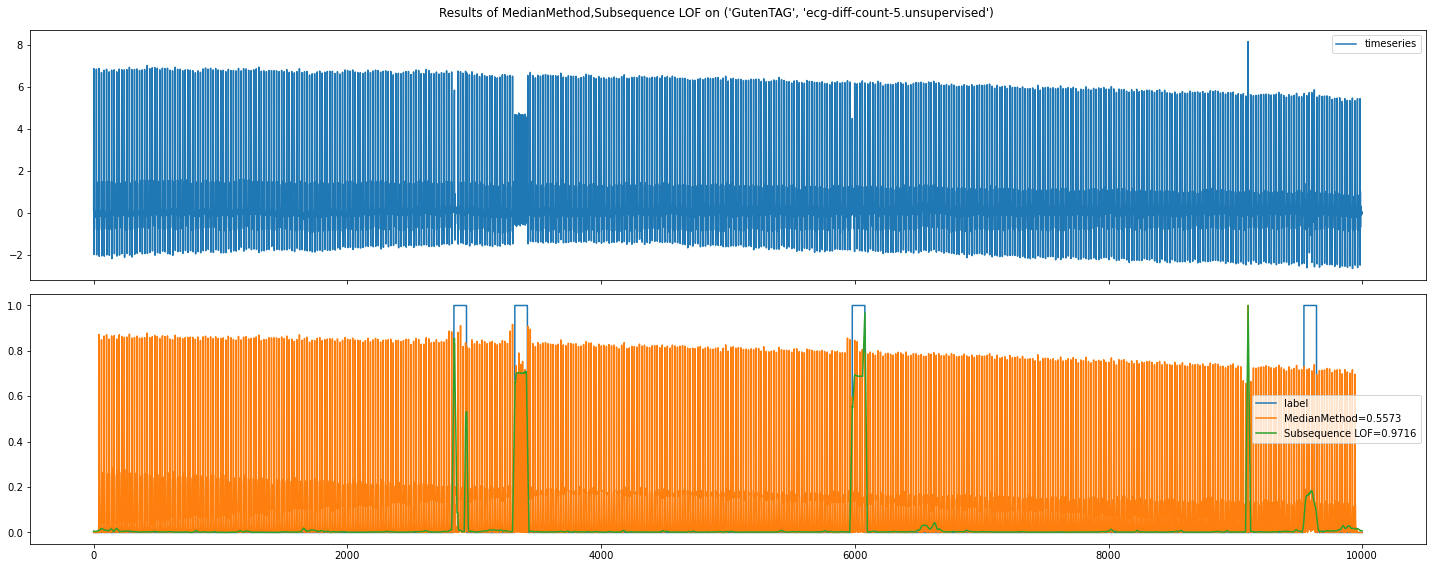

In [47]:
fig = plot_scores(["MedianMethod", "Subsequence LOF"], ("GutenTAG", "ecg-diff-count-5.unsupervised"))

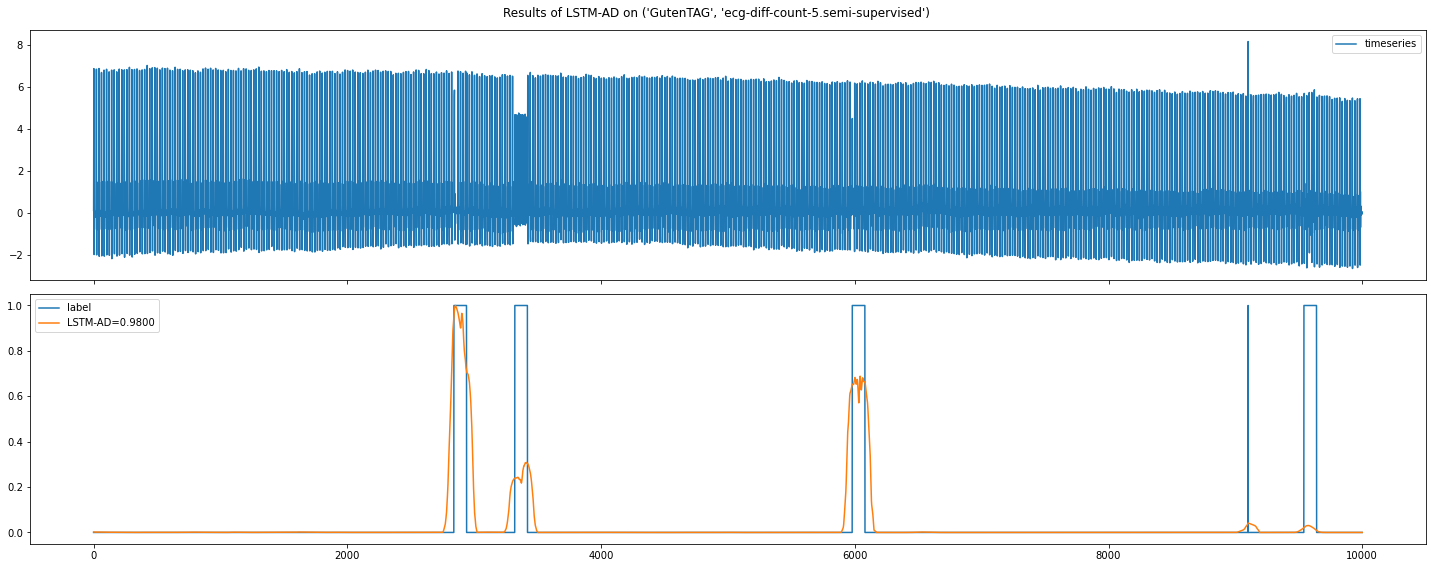

In [45]:
fig = plot_scores(["LSTM-AD"], ("GutenTAG", "ecg-diff-count-5.semi-supervised"))

In [53]:
df.loc[(df["algorithm"] == "Subsequence LOF") & (df["dataset"] == "ecg-diff-count-5.unsupervised"), "hyper_params"].item()

'{"distance_metric_order": 2, "leaf_size": 20, "n_jobs": 1, "n_neighbors": 50, "random_state": 42, "window_size": 20}'

### Algorithm problems grouped by algorithm training type

In [7]:
index_columns = ["algo_training_type", "algo_input_dimensionality", "algorithm"]
df_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
if "Status.TIMEOUT" not in df_error_counts.columns:
    df_error_counts["Status.TIMEOUT"] = np.nan
df_error_counts = df_error_counts.fillna(value=0).astype(np.int64)
df_error_counts = df_error_counts.reset_index().sort_values(by=["algo_input_dimensionality", "Status.ERROR"], ascending=False).set_index(index_columns)
df_error_counts["ALL"] = df_error_counts["Status.ERROR"] + df_error_counts["Status.OK"] + df_error_counts["Status.TIMEOUT"]

for tpe in ["SEMI_SUPERVISED", "SUPERVISED", "UNSUPERVISED"]:
    if tpe in df_error_counts.index:
        print(tpe)
        if default_use_plotly:
            py.iplot(ff.create_table(df_error_counts.loc[tpe], index=True))
        else:
            display(df_error_counts.loc[tpe])

SEMI_SUPERVISED


status                                                  Status.ERROR  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                TARZAN                                  51   
                          OceanWNN                                46   
                          Donut                                   13   
                          Bagel                                    9   
                          SR-CNN                                   7   
                          ImageEmbeddingCAE                        6   
                          XGBoosting (RR)                          3   
                          Random Forest Regressor (RR)             0   
MULTIVARIATE              DeepAnT                                379   
                          LSTM-AD                                226   
                          EncDec-AD                              113   
                          Random Black Forest (RR)                75   
                          TAnoGan                                 52   
                          Telemanom                               51   
                          OmniAnomaly                             27   
                          LaserDBN                                17   
                          Hybrid KNN                              12   
                          HealthESN                                7   
                          RobustPCA                                0   

status                                                  Status.OK  \
algo_input_dimensionality algorithm                                 
UNIVARIATE                TARZAN                              253   
                          OceanWNN                            258   
                          Donut                               287   
                          Bagel                               208   
                          SR-CNN                              194   
                          ImageEmbeddingCAE                   298   
                          XGBoosting (RR)                     301   
                          Random Forest Regressor (RR)        250   
MULTIVARIATE              DeepAnT                               0   
                          LSTM-AD                              87   
                          EncDec-AD                            66   
                          Random Black Forest (RR)            284   
                          TAnoGan                             106   
                          Telemanom                           327   
                          OmniAnomaly                         352   
                          LaserDBN                            288   
                          Hybrid KNN                          319   
                          HealthESN                            23   
                          RobustPCA                           331   

status                                                  Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                          
UNIVARIATE                TARZAN                                     0  304  
                          OceanWNN                                   0  304  
                          Donut                                      4  304  
                          Bagel                                     87  304  
                          SR-CNN                                   103  304  
                          ImageEmbeddingCAE                          0  304  
                          XGBoosting (RR)                            0  304  
                          Random Forest Regressor (RR)              54  304  
MULTIVARIATE              DeepAnT                                    0  379  
                          LSTM-AD                                   66  379  
                          EncDec-AD                                200  379  
                       

SUPERVISED


status                                                   Status.ERROR  \
algo_input_dimensionality algorithm                                     
MULTIVARIATE              MultiHMM                                  5   
                          Normalizing Flows                         2   
                          Hybrid Isolation Forest (HIF)             0   

status                                                   Status.OK  \
algo_input_dimensionality algorithm                                  
MULTIVARIATE              MultiHMM                               1   
                          Normalizing Flows                      1   
                          Hybrid Isolation Forest (HIF)          5   

status                                                   Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                           
MULTIVARIATE              MultiHMM                                    0    6  
                          Normalizing Flows                           3    6  
                          Hybrid Isolation Forest (HIF)               1    6

UNSUPERVISED


status                                                     Status.ERROR  \
algo_input_dimensionality algorithm                                       
UNIVARIATE                S-H-ESD (Twitter)                         444   
                          SAND                                      184   
                          VALMOD                                    168   
                          Triple ES (Holt-Winter's)                  78   
                          Series2Graph                               45   
                          NormA                                      39   
                          PST                                        33   
                          HOT SAX                                    19   
                          Left STAMPi                                12   
                          ARIMA                                       4   
                          PhaseSpace-SVM                              3   
                          MedianMethod                                1   
                          NumentaHTM                                  1   
                          DSPOT                                       0   
                          DWT-MLEAD                                   0   
                          FFT                                         0   
                          GrammarViz                                  0   
                          PCI                                         0   
                          SSA                                         0   
                          STAMP                                       0   
                          STOMP                                       0   
                          Spectral Residual (SR)                      0   
                          Subsequence IF                              0   
                          Subsequence LOF                             0   
                          TSBitmap                                    0   
MULTIVARIATE              DBStream                                  719   
                          COF                                       374   
                          k-Means                                   170   
                          normal                                     93   
                          IF-LOF                                     47   
                          CBLOF                                      23   
                          Torsk                                      23   
                          COPOD                                      20   
                          HBOS                                       20   
                          Isolation Forest (iForest)                 20   
                          KNN                                        20   
                          LOF                                        20   
                          PCC                                        20   
                          Extended Isolation Forest (EIF)             0   

status                                                     Status.OK  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                S-H-ESD (Twitter)                      294   
                          SAND                                   508   
                          VALMOD                                 558   
                          Triple ES (Holt-Winter's)              525   
                          Series2Graph                           693   
                          NormA                                  621   
                          PST                                    705   
                          HOT SAX                                555   
                          Left STAMPi                            710   
                          ARIMA                                  676   
                          PhaseSpace-SVM                    

### Summary

In [8]:
df_error_summary = pd.DataFrame(df_error_counts.sum(axis=0))
df_error_summary.columns = ["count"]
all_count = df_error_summary.loc["ALL", "count"]
df_error_summary["percentage"] = df_error_summary / all_count
df_error_summary.style.format({"percentage": "{:06.2%}".format})

,count,percentage
status,,
Status.ERROR,3701,09.74%
Status.OK,32062,84.39%
Status.TIMEOUT,2228,05.86%
ALL,37991,100.00%


Inspect errors of a specific algorithm:

In [9]:
ok = "- OK -"
oom = "- OOM -"
timeout = "- TIMEOUT -"
error_mapping = {
    "TimeoutError": timeout,
    "status code '137'": oom,
    "MemoryError: Unable to allocate": oom,
    "ValueError: Expected 2D array, got 1D array instead": "Wrong shape error",
    "could not broadcast input array from shape": "Wrong shape error",
    "not aligned": "Wrong shape error",  # shapes (20,) and (19,500) not aligned
    "array must not contain infs or NaNs": "unexpected Inf or NaN",
    "contains NaN": "unexpected Inf or NaN",
    "cannot convert float NaN to integer": "unexpected Inf or NaN",
    "Error(s) in loading state_dict": "Model loading error",
    "EOFError": "Model loading error",
    "Restoring from checkpoint failed": "Model loading error",
    "RecursionError: maximum recursion depth exceeded in comparison": "Max recursion depth exceeded",
    "but PCA is expecting": "BROKEN Exathlon DATASETS",  # ValueError: X has 44 features, but PCA is expecting 43 features as input.
    "input.size(-1) must be equal to input_size": "BROKEN Exathlon DATASETS",
    "ValueError: The condensed distance matrix must contain only finite values.": "LinAlgError",
    "LinAlgError": "LinAlgError",
    "NameError: name 'nan' is not defined": "Not converged",
    "Could not form valid cluster separation": "Not converged",
    "contamination must be in": "Invariance/assumption not met",
    "Data must not be constant": "Invariance/assumption not met",
    "Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data": "Invariance/assumption not met",
    "ValueError: Anom detection needs at least 2 periods worth of data": "Invariance/assumption not met",
    "`dataset` input should have multiple elements": "Invariance/assumption not met",
    "Cannot take a larger sample than population": "Invariance/assumption not met",
    "num_samples should be a positive integer value": "Invariance/assumption not met",
    "Cannot use heuristic method to compute initial seasonal and levels with less than periods + 10 datapoints": "Invariance/assumption not met",
    "ValueError: The window size must be less than or equal to 0": "Invariance/assumption not met",
    "The window size must be less than or equal to": "Incompatible parameters",
    "window_size has to be greater": "Incompatible parameters",
    "Set a higher piecewise_median_period_weeks": "Incompatible parameters",
    "OutOfBoundsDatetime: cannot convert input with unit 'm'": "Incompatible parameters",
    "`window_size` must be at least 4": "Incompatible parameters",
    "elements of 'k' must be between": "Incompatible parameters",
    "Expected n_neighbors <= n_samples": "Incompatible parameters",
    "PAA size can't be greater than the timeseries size": "Incompatible parameters",
    "All window sizes must be greater than or equal to": "Incompatible parameters",
    "ValueError: __len__() should return >= 0": "Bug",
    "stack expects a non-empty TensorList": "Bug",
    "expected non-empty vector": "Bug",
    "Found array with 0 feature(s)": "Bug",
    "ValueError: On entry to DLASCL parameter number 4 had an illegal value": "Bug",
    "Sample larger than population or is negative": "Bug",
    "ZeroDivisionError": "Bug",
    "IndexError": "Bug",
    "status code '139'": "Bug",
    "replacement has length zero": "Bug",
    "missing value where TRUE/FALSE needed": "Bug",
    "invalid subscript type 'list'": "Bug",
    "subscript out of bounds": "Bug",
    "invalid argument to unary operator": "Bug",
    "negative length vectors are not allowed": "Bug",
    "negative dimensions are not allowed": "Bug",
    "`std` must be positive": "Bug",
    "does not have key": "Bug",  # State '1' does not have key '1'
    "Less than 2 uniques breaks left": "Bug",
    "The encoder for value is invalid": "Bug",
    "arange: cannot compute length": "Bug",
    "n_components=3 must be between 0 and min(n_samples, n_features)": "Bug",
}

def get_folder(index):
    series = df.loc[index]
    path = (
        result_path /
        series["algorithm"] /
        series["hyper_params_id"] /
        series["collection"] /
        series["dataset"] /
        str(series["repetition"])
    )
    return path
    
def category_from_logfile(logfile):
    with logfile.open() as fh:
        log = fh.read()
    for error in error_mapping:
        if error in log:
            return error_mapping[error]
    #print(log)
    return "other"
    
def extract_category(series):
    status = series["status"]
    msg = series["error_message"]
    if status == "Status.OK":
        return ok
    elif status == "Status.TIMEOUT":
        return timeout
    # status is ERROR:
    elif "DockerAlgorithmFailedError" in msg:
        path = get_folder(series.name) / "execution.log"
        if path.exists():
            return category_from_logfile(path)
        return "DockerAlgorithmFailedError"
    else:
        m = re.search("^([\w]+)\(.*\)", msg)
        if m:
            error = m.group(1)
        else:
            error = msg
        return f"TimeEval:{error}"

df["error_category"] = df.apply(extract_category, axis="columns", raw=False)
df_error_category_overview = df.pivot_table(index="error_category", columns="algorithm", values="repetition", aggfunc="count")
df_error_category_overview.insert(0, "ALL (sum)", df_error_category_overview.sum(axis=1))

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_error_category_overview.style.format("{:.0f}", na_rep=""))

algorithm,ALL (sum),ARIMA,Bagel,CBLOF,COF,COPOD,DBStream,DSPOT,DWT-MLEAD,DeepAnT,Donut,EncDec-AD,Extended Isolation Forest (EIF),FFT,GrammarViz,HBOS,HOT SAX,HealthESN,Hybrid Isolation Forest (HIF),Hybrid KNN,IF-LOF,ImageEmbeddingCAE,Isolation Forest (iForest),KNN,LOF,LSTM-AD,LaserDBN,Left STAMPi,MedianMethod,MultiHMM,NormA,Normalizing Flows,NumentaHTM,OceanWNN,OmniAnomaly,PCC,PCI,PST,PhaseSpace-SVM,Random Black Forest (RR),Random Forest Regressor (RR),RobustPCA,S-H-ESD (Twitter),SAND,SR-CNN,SSA,STAMP,STOMP,Series2Graph,Spectral Residual (SR),Subsequence IF,Subsequence LOF,TARZAN,TAnoGan,TSBitmap,Telemanom,Torsk,Triple ES (Holt-Winter's),VALMOD,XGBoosting (RR),k-Means,normal
error_category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
- OK -,32062,676,208,900,549,903,203,686,738,,287,66,923,738,711,903,555,23,5,319,870,298,903,903,902,87,288,710,737,1,621,1,733,258,352,903,738,705,626,284,250,331,294,508,194,733,699,723,693,738,738,720,253,106,738,327,737,525,558,301,753,830
- OOM -,1257,,,,354,,77,,,,3,96,,,,,10,7,,6,,,,,,210,1,,,,13,2,,,20,,,32,,75,,,,12,,,,,,,,,,48,,50,,,77,3,161,
- TIMEOUT -,2228,58,87,,,,1,52,,,4,200,,,27,,164,349,1,48,6,,,,1,66,74,16,,,78,3,4,,,,,,109,20,54,48,,46,103,5,39,15,,,,18,,221,,1,163,135,12,,,
Bug,874,,9,,,,404,,,12,10,17,,,,,9,,,6,1,6,,,,16,16,,,,9,,1,43,,,,1,,,,,,162,,,,,31,,,,20,,,,2,,90,,9,
Incompatible parameters,663,,,,,,227,,,,,,,,,,,,,,,,,,,,,2,,,,,,,,,,,,,,,434,,,,,,,,,,,,,,,,,,,
Invariance/assumption not met,121,,,,,,,,,,,,,,,,,,,,,,,,,,,10,,,,,,,,,,,,,,,10,,7,,,,12,,,,,4,,,,78,,,,
LinAlgError,21,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,17,,,,,,,,,,,,,,,,,,2,,,,,,,,,,,,,
Max recursion depth exceeded,30,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,30,,,,,,,,,
Model loading error,5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,5,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [11]:
df[
    (df["error_category"] == "TimeEval:KilledWorker") &
    (df["algorithm"] != "normal")
]

,algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,...,error_message,repetition,hyper_params,hyper_params_id,ROC_AUC,PR_AUC,RANGE_PR_AUC,AVERAGE_PRECISION,overall_time,error_category
33500,TARZAN,Keogh,qtdbSel100MLII,SEMI_SUPERVISED,UNIVARIATE,SEMI_SUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,KilledWorker('TARZAN-Keogh-qtdbSel100MLII-2de8...,1,"{""alphabet_size"": 4, ""anomaly_window_size"": 20...",2de8bcd2ea03f0647d6008f4dc6c79d4,NaN,NaN,NaN,NaN,0.0,TimeEval:KilledWorker
33854,Telemanom,Keogh,qtdbSel100MLII,SEMI_SUPERVISED,MULTIVARIATE,SEMI_SUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,KilledWorker('Telemanom-Keogh-qtdbSel100MLII-d...,1,"{""batch_size"": 64, ""dropout"": 0.5, ""early_stop...",d5b6a765591ff0db43c6d6369cb85f98,NaN,NaN,NaN,NaN,0.0,TimeEval:KilledWorker
34250,Torsk,Keogh,e0509m_rand_50,UNSUPERVISED,MULTIVARIATE,SEMI_SUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,KilledWorker('Torsk-Keogh-e0509m_rand_50-de9b8...,1,"{""context_window_size"": 10, ""density"": 0.01, ""...",de9b8b973f50539dc5ef4c8c1a722f4b,NaN,NaN,NaN,NaN,0.0,TimeEval:KilledWorker
36585,VALMOD,Keogh,e0509m_rand_50,UNSUPERVISED,UNIVARIATE,SEMI_SUPERVISED,UNIVARIATE,NaN,NaN,NaN,...,KilledWorker('VALMOD-Keogh-e0509m_rand_50-f74f...,1,"{""exclusion_zone"": 0.5, ""heap_size"": 50, ""max_...",f74fae266c1a6921831b154bf3f27c7f,NaN,NaN,NaN,NaN,0.0,TimeEval:KilledWorker


In [ ]:
df[
    #(df["error_category"] == "TimeEval:KilledWorker") &
    (df["algorithm"] == "VALMOD")
][["algorithm", "collection", "dataset", "status", "error_message", "error_category"]]

There's a labelling problem with the dataset `"KDD-TSAD", "108_UCR_Anomaly_NOISEresperation2"`.
The raw dataset file specifies an anomaly-location of $168250$ until $168250$.
Our preprocessing interprets those boundaries as ($[168250, 168250)$: begin incluse, end exclusive) and does not add an anomaly label (anomaly window size is $0$).
This logic keeps the anomaly window sizes for other datasets at good-looking sizes, e.g. an anomaly-location $[7000, 7050)$ will result in a window size of $50$ (and not $51$, when considering the right bound ($7050$) inclusive).
However, this (and at least two other) dataset will have no anomaly then.

In [ ]:
fig = plot_scores("Series2Graph", ("KDD-TSAD", "108_UCR_Anomaly_NOISEresperation2"))